# Разведочный анализ датасета "Т-Банк: звонки операторов клиентам"

Цель: Найти закономерности, чтобы сформулировать гипотезы по улучшению пользовательского опыта и увеличению процента успешных звонков. Проверить эти гипотезы статистическими методами.


In [23]:
import pandas as pd

df = pd.read_csv("sale_tasks_dataset.csv", decimal=',', parse_dates=['finish_dttm'])

print(df.head())
print(df.info())

   customer_id   age gender_cd region_size foreign_flg entrepreneur_flg  \
0    422206773  58.0         F         NaN         NaN              NaN   
1    348648289  44.0         M       rural         0.0              0.0   
2    345496995  23.0         F        town         0.0              0.0   
3    182783192  34.0         M        town         0.0              0.0   
4    138498254  30.0         M         NaN         NaN              NaN   

  auto_flg traveler_flg partnership_flg child_amt  ... state_talk_time_sec  \
0      NaN          NaN             NaN       NaN  ...                67.0   
1      0.0          0.0             1.0       1.0  ...               151.0   
2      1.0          0.0             1.0       0.0  ...                68.0   
3      0.0          0.0             0.0       0.0  ...               738.0   
4      NaN          NaN             NaN       NaN  ...                39.0   

  wo_hit_status_result_desc              wo_hit_status_reason_desc  \
0         

# Предобработка данных

Проведем предобработку: удалим дубликаты, нерелевантные для анализа колонки и выбросы. Приведем оставшиеся колонки к нужным типам.

In [24]:
dups_key = df.duplicated(subset=["customer_id", "finish_dttm"]).sum()
print(f"Дубликатов по (customer_id, finish_dttm): {dups_key}")

Дубликатов по (customer_id, finish_dttm): 3


In [25]:
df = df.drop_duplicates(subset=["customer_id", "finish_dttm"]).reset_index(drop=True)

Оставим лишь признаки, основываясь на которых, мы можем улучшить опыт пользователя. Удалим следующие признаки:

1) Идентификаторы

2) Параметры 3-11 - они могут помочь нам понять потребности клиента и решить, какой продукт ему стоит предложить, но сейчас я не буду фокусироваться на этом, это слишком объемная задача

3) Параметры 18, 20 - это более сложные метрики успешности звонка, чем wo_hit_status_result_desc, но сейчас нам будет достаточно его.

4) Параметры 26-27 - у меня нет идей, как можно их использовать.

In [26]:
cols_to_drop = [
    # ID-поля
    "customer_id", "employee_id",
    # 3–11: демографические/соц-факторы клиента
    "region_size", "foreign_flg", "entrepreneur_flg",
    "auto_flg", "traveler_flg", "partnership_flg", "child_amt", "realty_type",
    "segment_cd",
    # 18, 20: сложные метрики звонка
    "state_talk_time_sec", "wo_hit_status_reason_desc",
    # 26–27: демографические/соц-факторы работника
    "emp_marital_status_cd", "emp_citizenship_country_cd", "emp_children_cnt"
]

df = df.drop(columns=cols_to_drop).reset_index(drop=True)

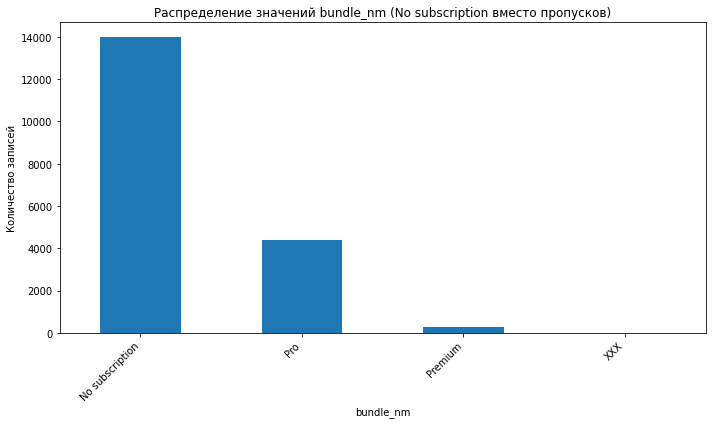

In [27]:
import matplotlib.pyplot as plt

df["bundle_nm_filled"] = df["bundle_nm"].fillna("No subscription")

bundle_counts = df["bundle_nm_filled"].value_counts()

# Распределение bundle_nm
plt.figure(figsize=(10, 6))
bundle_counts.plot(kind="bar")
plt.xlabel("bundle_nm")
plt.ylabel("Количество записей")
plt.title("Распределение значений bundle_nm (No subscription вместо пропусков)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Premium и ХХХ представлены в малом количестве - удалим клиентов этих категорий, оставим только флаг Pro-подписки:

In [28]:
df = df[df["bundle_nm"].isin(["Pro"]) | df["bundle_nm"].isna()].copy()
df["pro_flag"] = df["bundle_nm"] == "Pro"

df = df.drop(columns=["bundle_nm", "bundle_nm_filled"])

In [29]:
# Приведем возраст и доходы к числовым типам
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["confirmed_income"] = pd.to_numeric(df["confirmed_income"], errors="coerce")
df["predicted_income"] = pd.to_numeric(df["predicted_income"], errors="coerce")

# Заменим пол и успешность на флаги
df["call_success_flag"] = df["wo_hit_status_result_desc"]== "Дозвон, Успешно"

df["cl_male_flag"] = df["gender_cd"] == "M"
df["emp_male_flag"] = df["emp_gender_cd"] == "M"

df = df.drop(columns=["wo_hit_status_result_desc", "gender_cd", "emp_gender_cd"])

In [30]:
# Удалим выбросы
age_mask = df["age"].between(10, 90) & df["emp_age"].between(10, 90)
income_threshold = df["predicted_income"].quantile(0.99)
income_mask = df["predicted_income"] <= income_threshold

df = df[age_mask & income_mask | df["predicted_income"].isna()].copy()

In [31]:
# Посмотрим на итоговый df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18345 entries, 0 to 18687
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   age                  18167 non-null  float64       
 1   confirmed_income     1360 non-null   float64       
 2   predicted_income     3935 non-null   float64       
 3   product_cd           18345 non-null  object        
 4   functional_cd        18345 non-null  object        
 5   finish_dttm          18345 non-null  datetime64[ns]
 6   emp_age              18345 non-null  int64         
 7   emp_work_months_cnt  18345 non-null  int64         
 8   pro_flag             18345 non-null  bool          
 9   call_success_flag    18345 non-null  bool          
 10  cl_male_flag         18345 non-null  bool          
 11  emp_male_flag        18345 non-null  bool          
dtypes: bool(4), datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 1.3+ MB
Non

# 1) Влияние опыта работы оператора на конверсию

### Изучение зависимости

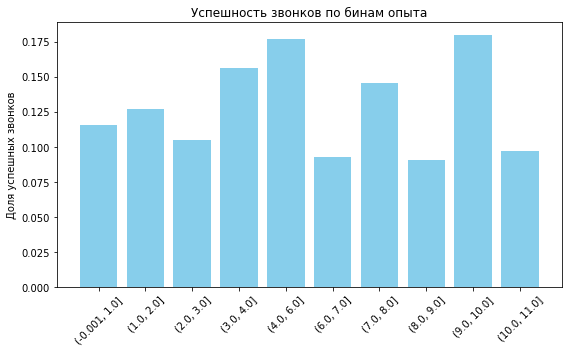

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Биннинг по опыту
df["exp_bin_10"] = pd.qcut(df["emp_work_months_cnt"], q=10)

metrics_10 = (
    df.groupby("exp_bin_10", observed=True)
    .agg(
        success_rate=("call_success_flag", "mean"),
        avg_predicted_income=("predicted_income", "mean"),
        avg_confirmed_income=("confirmed_income", "mean")
    )
    .reset_index()
)


plt.figure(figsize=(8, 5))
plt.bar(metrics_10["exp_bin_10"].astype(str), metrics_10["success_rate"], color="skyblue")
plt.title("Успешность звонков по бинам опыта")
plt.ylabel("Доля успешных звонков")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Различия сотрудников разного опыта

Посмотрим, меняется ли тип задач и клиентов в зависимости от опыта сотрудника:

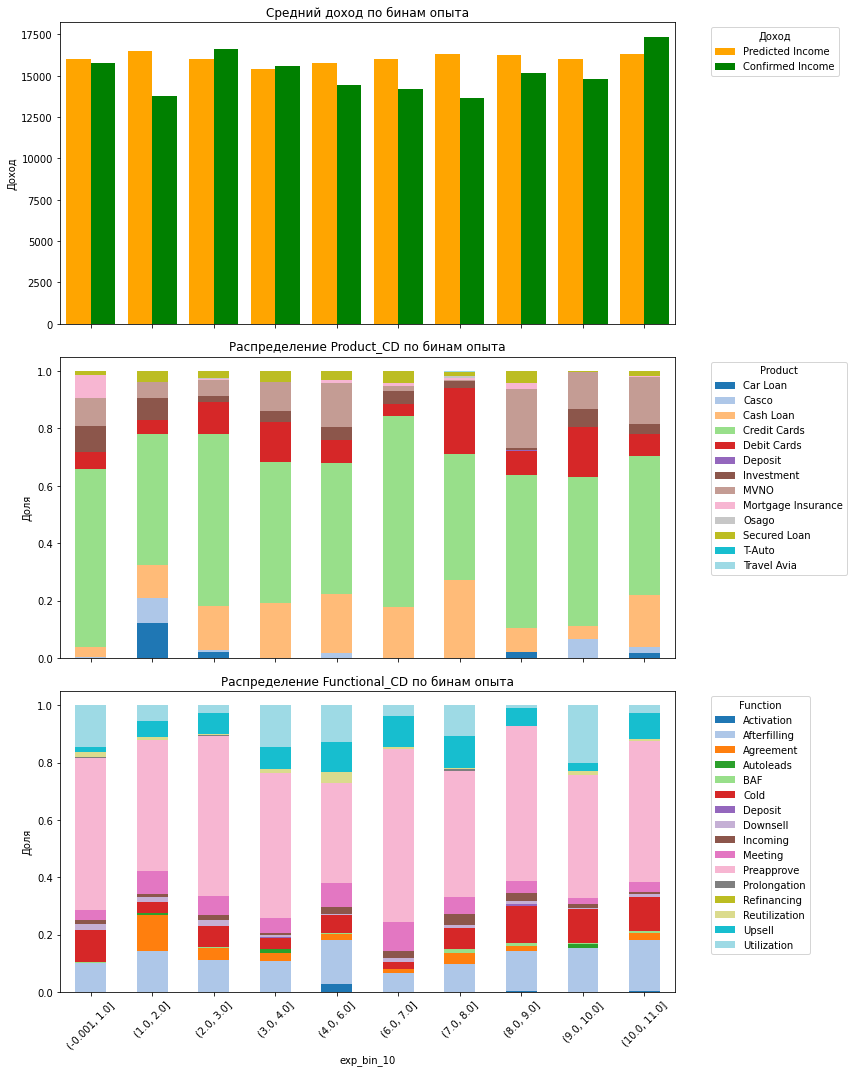

In [33]:
x = np.arange(len(metrics_10))
bar_width = 0.4

product_dist = df.groupby("exp_bin_10")["product_cd"].value_counts(normalize=True).unstack().fillna(0)
functional_dist = df.groupby("exp_bin_10")["functional_cd"].value_counts(normalize=True).unstack().fillna(0)

product_colors = plt.cm.tab20(np.linspace(0, 1, product_dist.shape[1]))
functional_colors = plt.cm.tab20(np.linspace(0, 1, functional_dist.shape[1]))

fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# 1. Доходы
axs[0].bar(x - bar_width/2, metrics_10["avg_predicted_income"], width=bar_width, label="Predicted Income", color="orange")
axs[0].bar(x + bar_width/2, metrics_10["avg_confirmed_income"], width=bar_width, label="Confirmed Income", color="green")
axs[0].set_title("Средний доход по бинам опыта")
axs[0].set_ylabel("Доход")
axs[0].set_xticks(x)
axs[0].set_xticklabels(metrics_10["exp_bin_10"].astype(str), rotation=45)
axs[0].legend(title="Доход", bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. product_cd
product_dist.plot(kind="bar", stacked=True, ax=axs[1], color=product_colors)
axs[1].set_title("Распределение Product_CD по бинам опыта")
axs[1].set_ylabel("Доля")
axs[1].legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].tick_params(axis="x", rotation=45)

# 3. functional_CD
functional_dist.plot(kind="bar", stacked=True, ax=axs[2], color=functional_colors)
axs[2].set_title("Распределение Functional_CD по бинам опыта")
axs[2].set_ylabel("Доля")
axs[2].legend(title="Function", bbox_to_anchor=(1.05, 1), loc='upper left')
axs[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


### Вывод
Судя по данным, успешность звонков не зависит от опыта сотрудника — метрика колеблется хаотично, без устойчивого тренда. При этом нельзя объяснить это тем, что более опытные сотрудники получают более сложных клиентов или задачи: распределения product_cd и functional_cd по уровням опыта также не демонстрируют закономерностей, а изменяются хаотично.

### Гипотеза по оптимизации затрат

Поскольку опыт сотрудника не влияет на его эффективность, нет смысла повышать ему зарплату или стремиться удержать его, если у нас имеется достаточный приток новых кадров.

In [34]:
df = df.drop(columns=["emp_work_months_cnt", "exp_bin_10"])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18345 entries, 0 to 18687
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   age                18167 non-null  float64       
 1   confirmed_income   1360 non-null   float64       
 2   predicted_income   3935 non-null   float64       
 3   product_cd         18345 non-null  object        
 4   functional_cd      18345 non-null  object        
 5   finish_dttm        18345 non-null  datetime64[ns]
 6   emp_age            18345 non-null  int64         
 7   pro_flag           18345 non-null  bool          
 8   call_success_flag  18345 non-null  bool          
 9   cl_male_flag       18345 non-null  bool          
 10  emp_male_flag      18345 non-null  bool          
dtypes: bool(4), datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 1.8+ MB


# 2) Роль наличия Pro-подписки у клиента

### Изучение зависимости

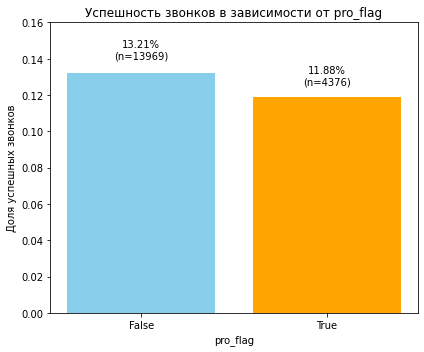

In [35]:
import matplotlib.pyplot as plt

# Группируем по pro_flag и считаем метрики
pro_success = (
    df.groupby("pro_flag", observed=True)
    .agg(
        success_rate=("call_success_flag", "mean"),
        count=("call_success_flag", "count")
    )
    .reset_index()
)

# График
fig, ax1 = plt.subplots(figsize=(6, 5))

bars = ax1.bar(
    pro_success["pro_flag"].astype(str),
    pro_success["success_rate"],
    color=["skyblue", "orange"]
)

ax1.set_title("Успешность звонков в зависимости от pro_flag")
ax1.set_ylabel("Доля успешных звонков")
ax1.set_xlabel("pro_flag")
ax1.set_ylim(0, 0.16)

for bar, count in zip(bars, pro_success["count"]):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height * 1.05,
        f"{height:.2%}\n(n={count})",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


### Статистическое тестирование

Кажется, наличие Pro-подписки снижает вероятность успешного звонка. Проверим это Z-тестом:

In [36]:
from statsmodels.stats.proportion import proportions_ztest

# Считаем количество успешных звонков и общее количество по группам
success_counts = df.groupby("pro_flag")["call_success_flag"].sum()
total_counts = df.groupby("pro_flag")["call_success_flag"].count()

# Выполняем z-тест
stat, pval = proportions_ztest(count=success_counts, nobs=total_counts)

print(f"z-statistic: {stat:.3f}")
print(f"p-value: {pval:.5f}")

# Интерпретация
alpha = 0.05
if pval < alpha:
    print("Различие статистически значимо: pro_flag влияет на успешность звонков.")
else:
    print("Нет статистически значимого различия: влияние pro_flag не подтверждено.")


z-statistic: 2.282
p-value: 0.02248
Различие статистически значимо: pro_flag влияет на успешность звонков.


### Гипотеза 2.1

Возможно, Pro-подписчики лучше ориентируются в линейке продуктов банка, поэтому они с большей вероятностью уже слышали о продукте, который им предлагает оператор, и уже решили, что он им не нужен.

Чтобы проверить эту гипотезу, нужно лучше изучить отличия 2 груп: обычных пользователей и Pro-подписчиков.

### Отличия Pro-подписчиков от обычных клиентов

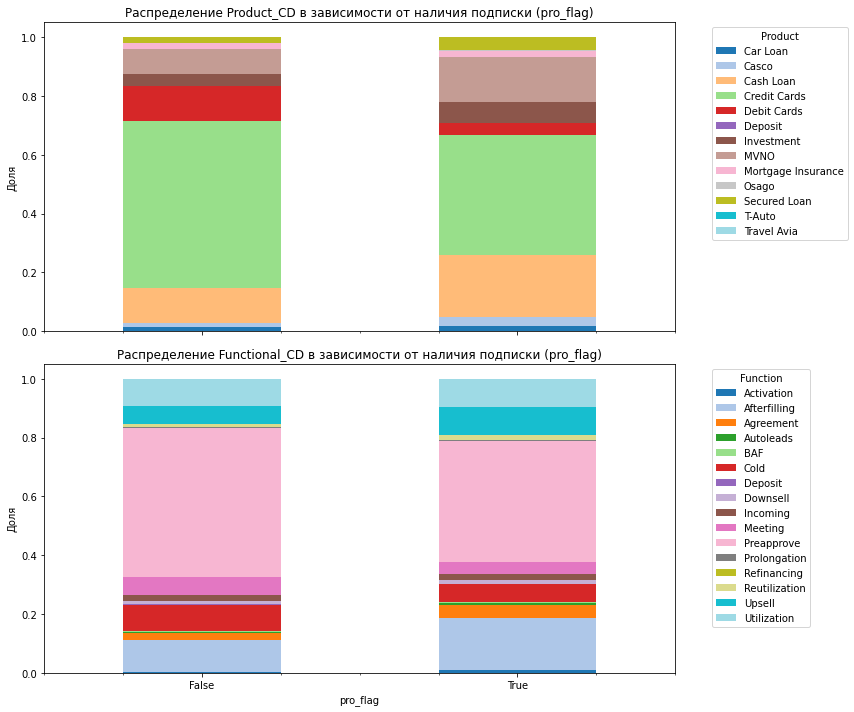

In [37]:
# Построим распределения product_cd и functional_cd в зависимости от pro_flag
product_dist_pro = df.groupby("pro_flag")["product_cd"].value_counts(normalize=True).unstack().fillna(0)
functional_dist_pro = df.groupby("pro_flag")["functional_cd"].value_counts(normalize=True).unstack().fillna(0)

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Цвета
product_colors = plt.cm.tab20(np.linspace(0, 1, product_dist_pro.shape[1]))
functional_colors = plt.cm.tab20(np.linspace(0, 1, functional_dist_pro.shape[1]))

# product_cd
product_dist_pro.plot(kind="bar", stacked=True, ax=axs[0], color=product_colors)
axs[0].set_title("Распределение Product_CD в зависимости от наличия подписки (pro_flag)")
axs[0].set_ylabel("Доля")
axs[0].legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].tick_params(axis="x", rotation=0)

# functional_cd
functional_dist_pro.plot(kind="bar", stacked=True, ax=axs[1], color=functional_colors)
axs[1].set_title("Распределение Functional_CD в зависимости от наличия подписки (pro_flag)")
axs[1].set_ylabel("Доля")
axs[1].legend(title="Function", bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()


### Гипотеза 2.2

Распределения по категориям заметно различаются. Вероятно, у большей части Pro-подписчиков уже оформлены основные банковские продукты, поэтому им предлагаются более нишевые или специфические предложения с изначально более низкой конверсией. Чтобы проверить эту гипотезу, рассмотрим успешность звонков в зависимости от категории и наличия подписки (ожидаем, что конверсия не зависит от наличия подписки, у Pro-подписчиков бОльшая доля категорий с низкой конверсией):

In [38]:
min_count = 30

# Уберем категории, в которых < min_count записей:
functional_counts = df["functional_cd"].value_counts()
product_counts = df["product_cd"].value_counts()

valid_functionals = functional_counts[functional_counts >= min_count].index
valid_products = product_counts[product_counts >= min_count].index

df = df[df["functional_cd"].isin(valid_functionals) & df["product_cd"].isin(valid_products)]

print(f"Удаленные категории (количество записей < {min_count}):")
print(product_counts[product_counts < min_count].to_string())
print()
print(functional_counts[functional_counts < min_count].to_string())

Удаленные категории (количество записей < 30):
Osago          21
Deposit        11
Travel Avia     5
T-Auto          2

Deposit        11
Refinancing     1


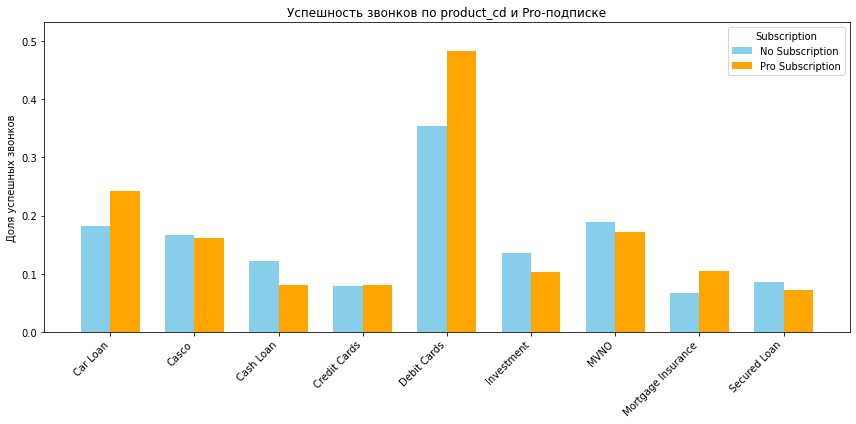

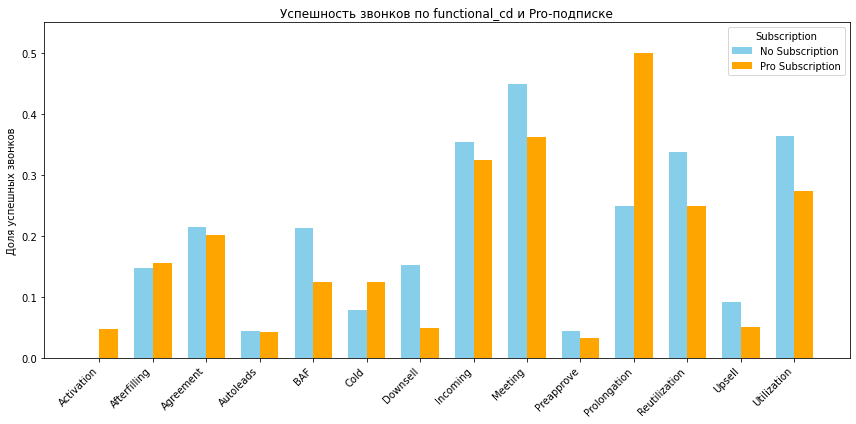

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_success_by_category(df, category_col, pro_flag_col="pro_flag"):
    """
    Строит сравнительный столбчатый график доли успешных звонков (call_success_flag)
    для каждой категории (category_col) в разрезе pro_flag
    """
    df_cat = df.dropna(subset=[category_col]).copy()

    grouped = (
        df_cat
        .groupby([category_col, pro_flag_col], observed=True)
        .agg(
            total_calls=("call_success_flag", "count"),
            successful_calls=("call_success_flag", "sum")
        )
        .reset_index()
    )
    grouped["success_rate"] = grouped["successful_calls"] / grouped["total_calls"]

    pivot = (
        grouped
        .pivot(
            index=category_col,
            columns=pro_flag_col,
            values="success_rate"
        )
        .fillna(0)
    )
    pivot.columns = ["success_rate_no_sub", "success_rate_pro"]

    # График
    categories = pivot.index.tolist()
    n = len(categories)
    fig_width = 12
    x = np.arange(n)
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(fig_width, 6))
    ax.bar(x - bar_width/2, pivot["success_rate_no_sub"], bar_width, label="No Subscription", color="skyblue")
    ax.bar(x + bar_width/2, pivot["success_rate_pro"],    bar_width, label="Pro Subscription", color="orange")

    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha="right")
    ax.set_ylabel("Доля успешных звонков")
    ax.set_title(f"Успешность звонков по {category_col} и Pro-подписке")

    max_rate = pivot.max().max()
    ax.set_ylim(0, max_rate * 1.1)
    ax.legend(title="Subscription")

    plt.tight_layout()
    plt.show()


# График для product_cd
plot_success_by_category(df, category_col="product_cd")

# График для functional_cd
plot_success_by_category(df, category_col="functional_cd")


### Возвращение к изначальной гипотезе

Все же, наличие Pro-подписки влияет на конверсию почти во всех категориях, но не всегда негативно: в ряде категорий, особенно в Prolongation и Debit cards, она, напротив, повышает конверсию.

Значит, гипотеза 1.2.1 лучше описывает данные.

Для проверки и количественной оценки этого эффекта:
1. Обучим логистическую регрессию на текущих данных (исключив finish_dttm, так как зависимость от него явно не линейная).
2. Оценим коэффициент при pro_flag.

In [40]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

data = df[[
    "age",
    "product_cd",
    "functional_cd",
    "emp_age",
    "pro_flag",
    "cl_male_flag",
    "emp_male_flag",
    "call_success_flag"
]].copy()
data = data.dropna(subset=["age", "emp_age", "product_cd", "functional_cd"])

# One-Hot кодирование product_cd и functional_cd
data_encoded = pd.get_dummies(
    data,
    columns=["product_cd", "functional_cd"],
    drop_first=True
)

X = data_encoded.drop(columns=["call_success_flag"])
y = data_encoded["call_success_flag"].astype(int)

X = sm.add_constant(X)

X = X.astype(float)

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.30,
    random_state=42
)

# Обучаем логистическую регрессию через statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit(disp=False)

print(result.summary())

                           Logit Regression Results                           
Dep. Variable:      call_success_flag   No. Observations:                12688
Model:                          Logit   Df Residuals:                    12661
Method:                           MLE   Df Model:                           26
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.1883
Time:                        13:59:40   Log-Likelihood:                -3936.8
converged:                       True   LL-Null:                       -4850.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -3.8804      1.044     -3.718      0.000      -5.926      -1.835
age                               0.0019      0.002      0.801      0.423 


Метрики качества на тестовой выборке:
Accuracy:       0.85
Precision:      0.422
Recall:         0.476
F1 Score:       0.447
ROC AUC Score:  0.777


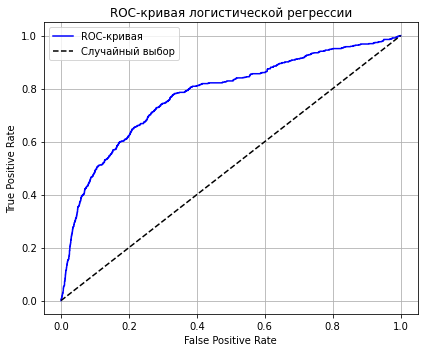

In [41]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

# Тестируем модель, срабатывание = вероятность > prob_threshold
prob_threshold = 0.25

y_pred_prob = result.predict(X_test)
y_pred = (y_pred_prob >= prob_threshold).astype(int)

print("\nМетрики качества на тестовой выборке:")
print("Accuracy:      ", round(accuracy_score(y_test, y_pred), 3))
print("Precision:     ", round(precision_score(y_test, y_pred), 3))
print("Recall:        ", round(recall_score(y_test, y_pred), 3))
print("F1 Score:      ", round(f1_score(y_test, y_pred), 3))
print("ROC AUC Score: ", round(roc_auc_score(y_test, y_pred_prob), 3))

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="ROC-кривая", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Случайный выбор")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая логистической регрессии")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Вывод

Модель логистической регрессии показывает, что наличие Pro-подписки статистически значимо влияет на вероятность успешного звонка (p < 0.05). Хотя общий эффект отрицательный (coef = -0.1419), при разборе по категориям влияние подписки оказывается разным.

Внесем в гипотезу 1.2.1 правки:

Повышенную конверсию в отдельных сегментах можно объяснить следующими особенностями Pro-подписчиков:

`Debit Cards`: Среди Pro-пользователей конверсия в продуктах, связанных с дебетовыми картами, значительно выше: Pro-пользователи получают расширенный кэшбэк, повышенные лимиты на переводы и снятие наличных, а также дешёвое обслуживание (см. [официальный сайт банка](https://www.tbank.ru/bank/help/general/pro/pro-subscription/benefits/?card=q5)).

`Prolongation и Afterfilling`. Высокая конверсия в этих категориях говорит о том, что Pro-подписчики более склонны к долгосрочным отношениям с банком. Платная подписка уже демонстрирует их лояльность, поэтому они охотнее соглашаются на продление или завершение оформления услуг.

### Гипотеза по улучшению продукта

Предложение по бонусам в других категориях:

В сегментах с низкой конверсией стоит ввести небольшие поощрения, аналогичные тем, что действуют для дебетовых карт. Например: «Мы обновили Pro-программу и добавили специальные бонусы в ещё нескольких ключевых категориях».

В таком случае, клиент, который уже узучил линейку продуктов банка, будет вынужден персмотреть свое решение. Даже умеренные улучшения условий создадут у Pro-клиентов ощущение дополнительной выгоды и, вероятно, повысят отклик.

Конечно, такие дополнительные бонусы имеют смысл вводить только если рост продаж в итоге покроет потерю прибыли от этих поощрений.

# 3) Влияние возрастной разницы между клиентом и оператором

Изучим, как возраст клиента и оператора влияют на успешность звонка:

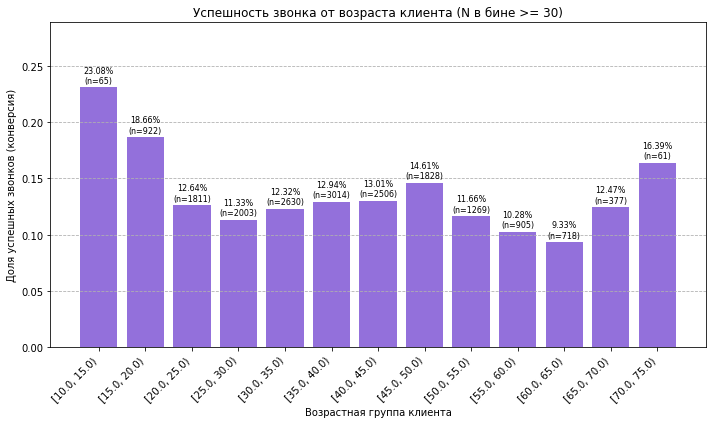

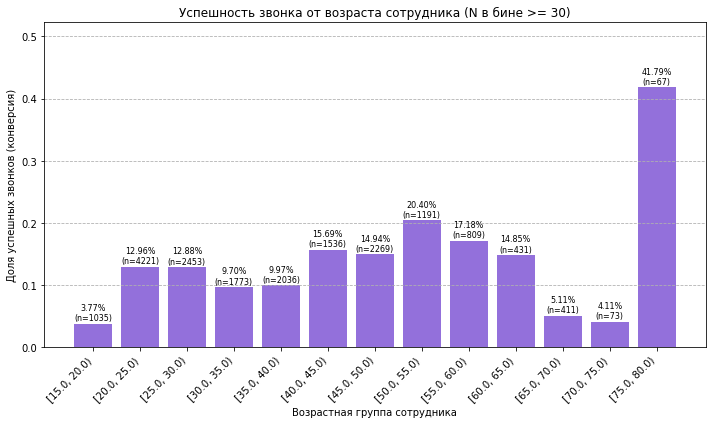

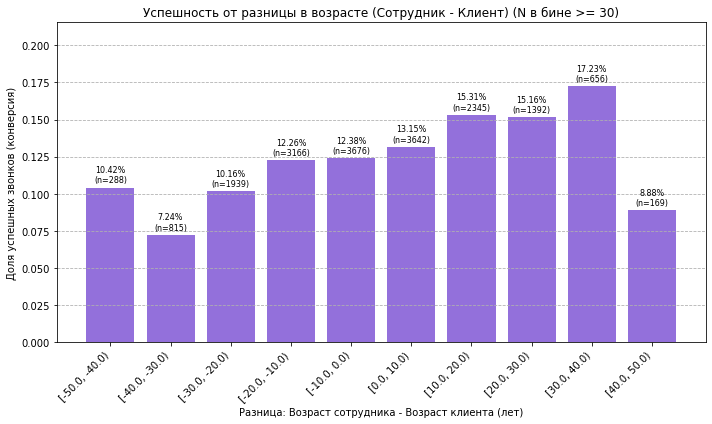

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_success_rate_by_binned_feature(
    df_source,
    feature_column_name,
    plot_title,
    xlabel_text,
    bin_width=5,
    min_bin_count=30,
    target_column_name='call_success_flag',
    plot_color='mediumpurple'
):
    """
    Строит график зависимости доли успеха от сгруппированного числового признака.
    Бины с малым количеством наблюдений отфильтровываются.
    """
    df_analysis = df_source.dropna(subset=[feature_column_name, target_column_name]).copy()

    if df_analysis.empty:
        print(f"Нет данных для {feature_column_name} после удаления пропусков.")
        return

    min_val = df_analysis[feature_column_name].min()
    max_val = df_analysis[feature_column_name].max()

    start_edge = np.floor(min_val / bin_width) * bin_width
    end_edge = np.ceil((max_val + 1e-9) / bin_width) * bin_width
    bins = np.arange(start_edge, end_edge + bin_width, bin_width)

    df_analysis['binned_feature'] = pd.cut(df_analysis[feature_column_name],
                                           bins=bins,
                                           right=False,
                                           include_lowest=True,
                                           duplicates='drop')

    stats = (
        df_analysis.groupby('binned_feature', observed=True)
        .agg(
            success_rate=(target_column_name, 'mean'),
            count=(target_column_name, 'count')
        )
        .reset_index()
    )
    stats_filtered = stats[stats['count'] >= min_bin_count].copy()

    if isinstance(stats_filtered['binned_feature'].dtype, pd.IntervalDtype):
        stats_filtered = stats_filtered.sort_values(
            by='binned_feature',
            key=lambda x: x.apply(lambda interval: interval.left if pd.notna(interval) else np.nan)
        )

    # График
    plt.figure(figsize=(max(10, len(stats_filtered) * 0.7), 6))
    bars = plt.bar(stats_filtered['binned_feature'].astype(str), stats_filtered['success_rate'], color=plot_color)

    plt.xlabel(xlabel_text)
    plt.ylabel("Доля успешных звонков (конверсия)")
    plt.title(f"{plot_title} (N в бине >= {min_bin_count})")
    plt.xticks(rotation=45, ha="right")

    max_y_val = stats_filtered['success_rate'].max()
    plt.ylim(0, max_y_val * 1.25 if max_y_val > 0 else 0.1)

    for bar_obj, count_val, rate_val in zip(bars, stats_filtered['count'], stats_filtered['success_rate']):
        yval = bar_obj.get_height()
        rate_text = f'{rate_val:.2%}' if pd.notna(rate_val) else 'N/A'
        plt.text(bar_obj.get_x() + bar_obj.get_width()/2.0, yval + 0.002, f'{rate_text}\n(n={count_val})',
                 ha='center', va='bottom', fontsize=8)

    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()


df['age_difference'] = df['emp_age'] - df['age']


# Возраст клиента
plot_success_rate_by_binned_feature(
    df,
    feature_column_name='age',
    plot_title="Успешность звонка от возраста клиента",
    xlabel_text="Возрастная группа клиента",
    min_bin_count=30,
    bin_width=5
)

# Возраст сотрудника
plot_success_rate_by_binned_feature(
    df,
    feature_column_name='emp_age',
    plot_title="Успешность звонка от возраста сотрудника",
    xlabel_text="Возрастная группа сотрудника",
    min_bin_count=30,
    bin_width=5
)

# Разница в возрасте
plot_success_rate_by_binned_feature(
    df,
    feature_column_name='age_difference',
    plot_title="Успешность от разницы в возрасте (Сотрудник - Клиент)",
    xlabel_text="Разница: Возраст сотрудника - Возраст клиента (лет)",
    min_bin_count=30,
    bin_width=10
)

Возраст клиента и возраст сотрудника: Графики успешности звонков в зависимости от этих показателей колеблются без явно интерпретируемой закономерности. Зависимость от возраста сотрудника выглядит чуть более упорядоченной, но в целом ни один из показателей по отдельности не дает очевидных выводов.

Разница в возрасте (сотрудник − клиент): Наиболее заметная картина получается при анализе возрастного разрыва. Если не учитывать крайние бины с относительно небольшим числом наблюдений, тренд близок к линейному: чем старше сотрудник по сравнению с клиентом, тем выше вероятность успеха.

### Гипотеза 3.1

Зависимость вероятности успешности звонка от разницы в возрасте линейна.
Как мы увидели в предыдущем пункте, стоит проверять наши гипотезы на устойчивость относительно категорий product_cd и functional_cd. Посторим графики для каждой категории:

--- Анализ по product_cd ---

График для product_cd: Debit Cards


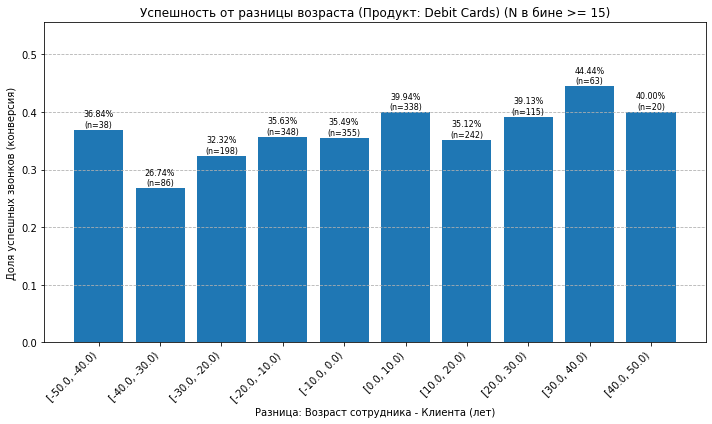


График для product_cd: Cash Loan


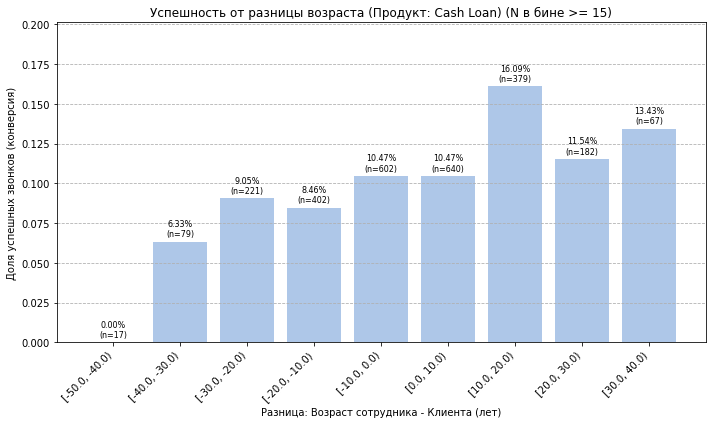


График для product_cd: Investment


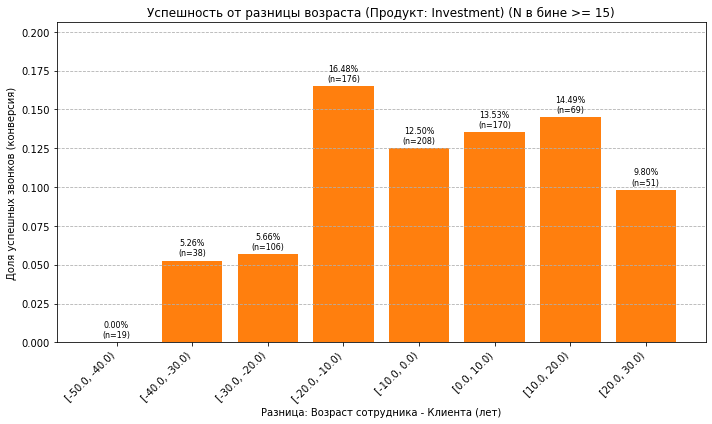


График для product_cd: Mortgage Insurance


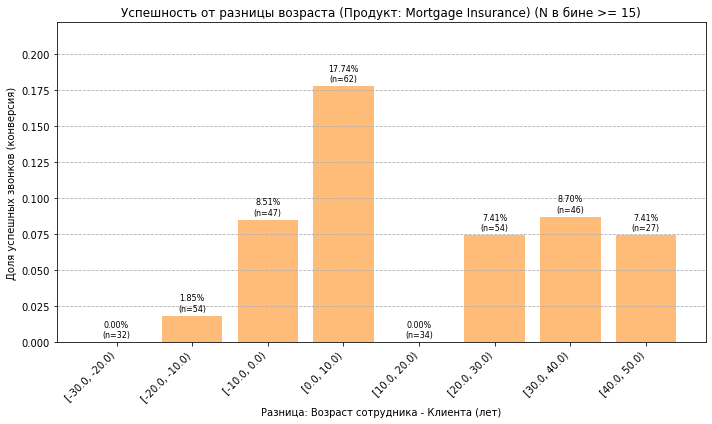


График для product_cd: Credit Cards


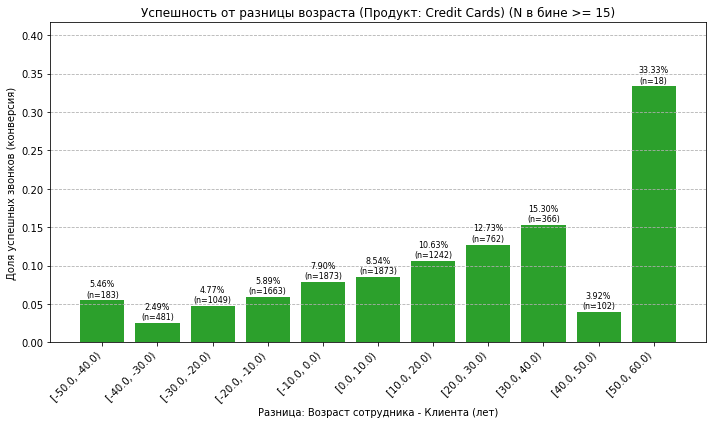


График для product_cd: MVNO


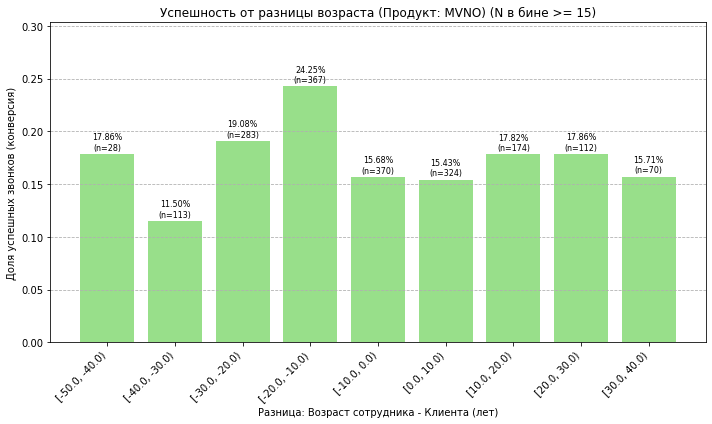


График для product_cd: Casco


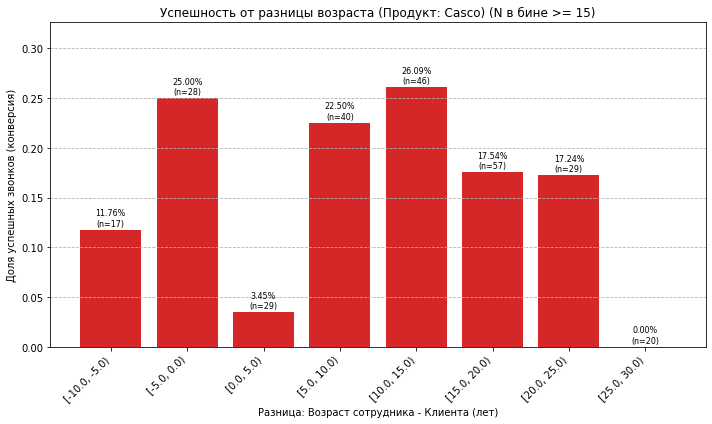


График для product_cd: Secured Loan


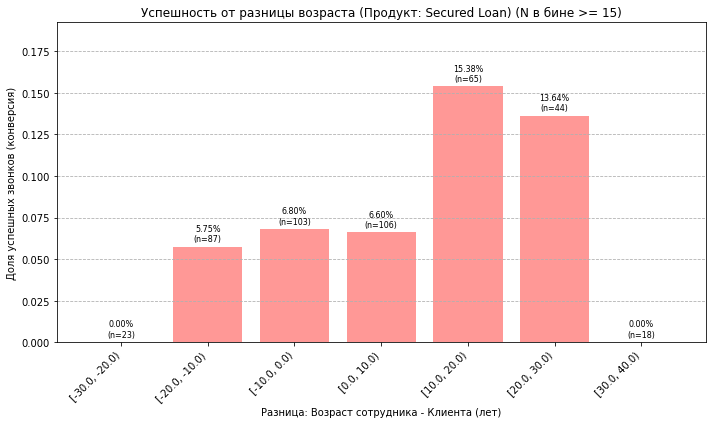


График для product_cd: Car Loan


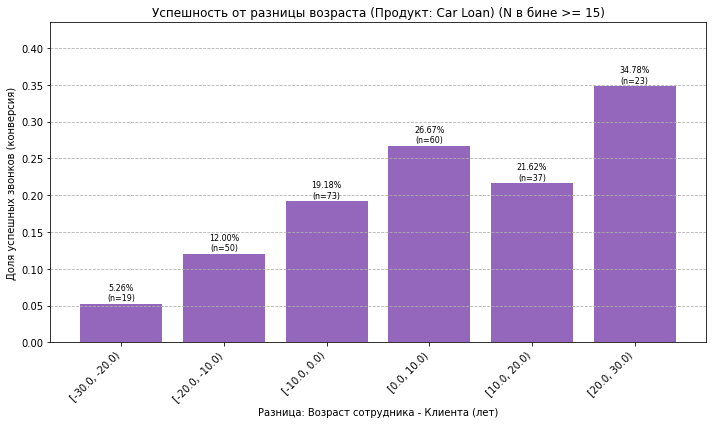



--- Анализ по functional_cd ---

График для functional_cd: Meeting


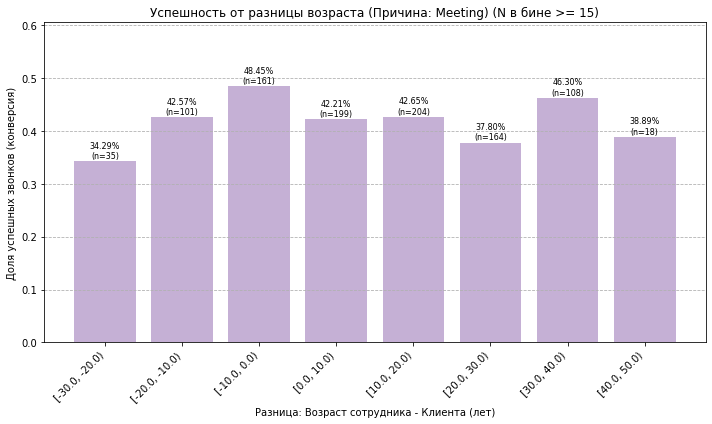


График для functional_cd: Upsell


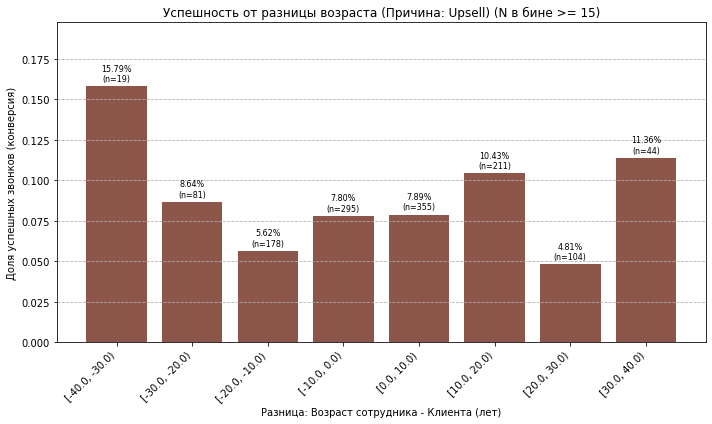


График для functional_cd: Utilization


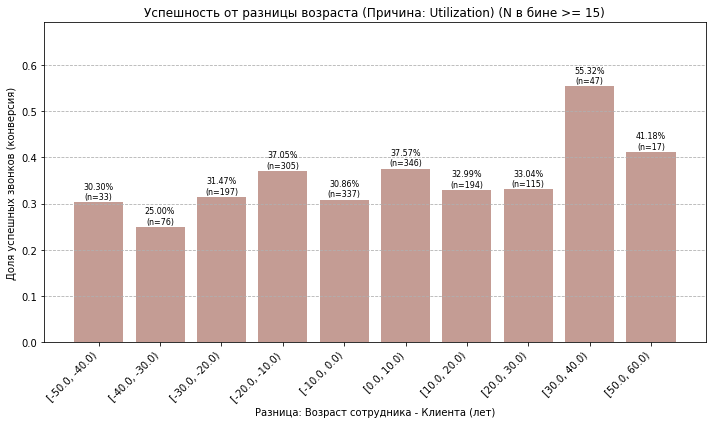


График для functional_cd: Incoming


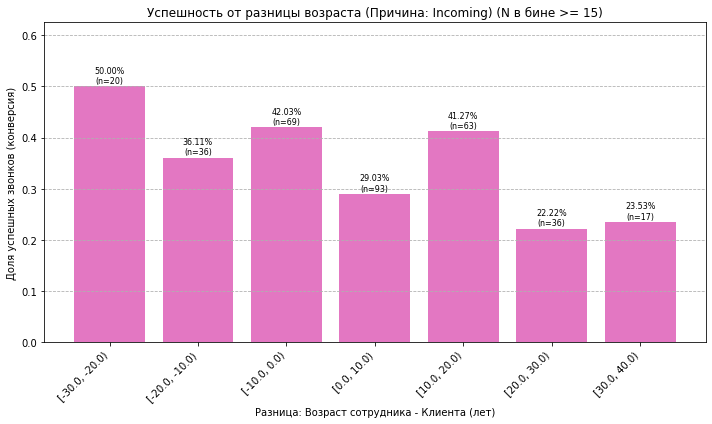


График для functional_cd: Preapprove


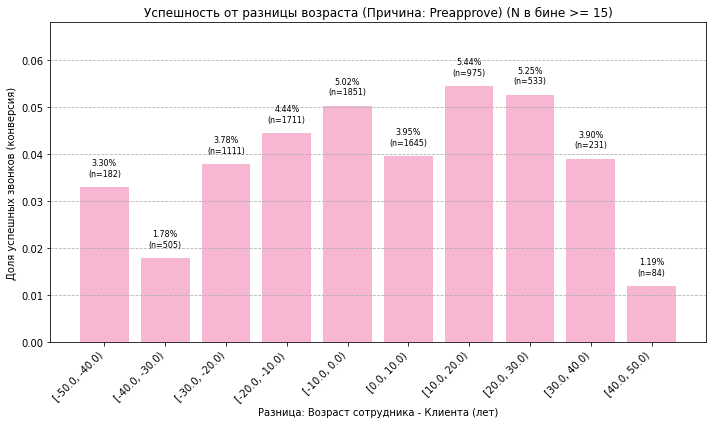


График для functional_cd: Cold


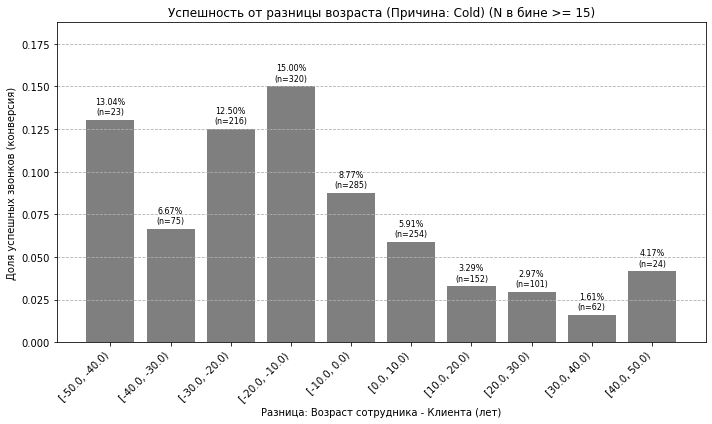


График для functional_cd: Afterfilling


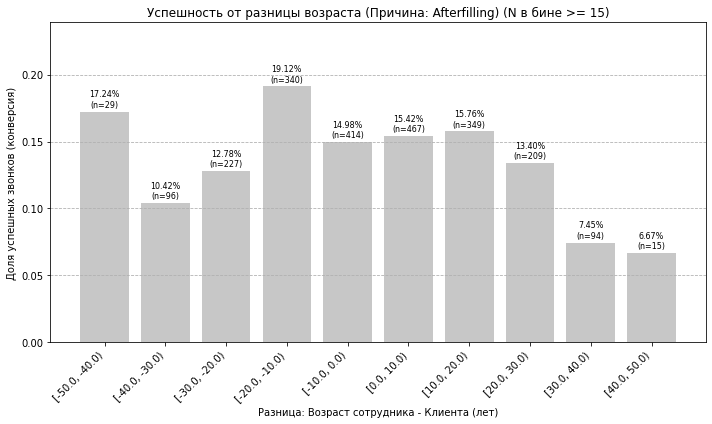


График для functional_cd: Reutilization


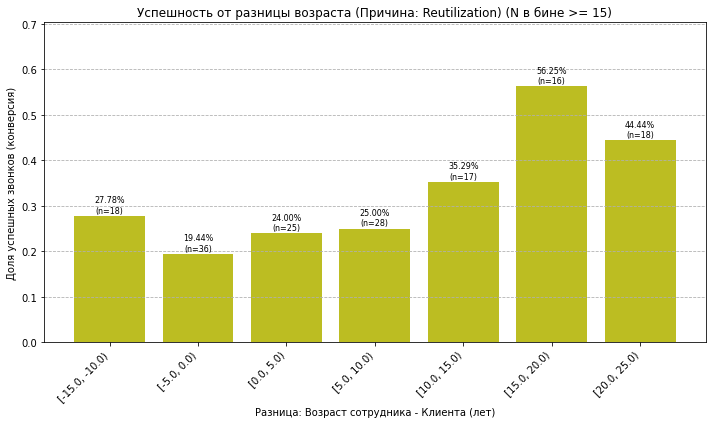

Пропускаем functional_cd 'Prolongation': слишком мало данных (22 записей)

График для functional_cd: Agreement


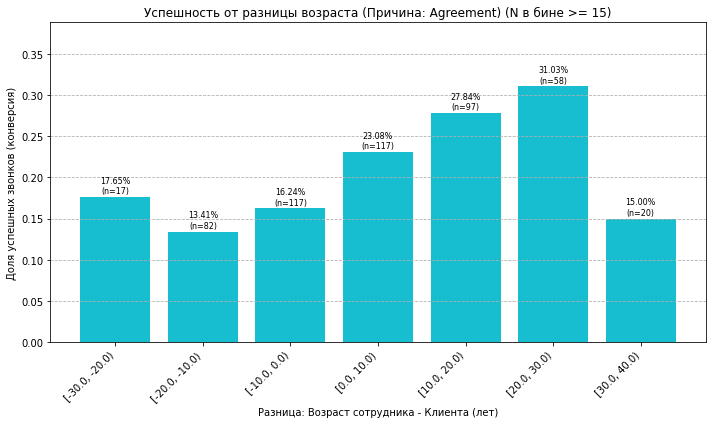

Пропускаем functional_cd 'BAF': слишком мало данных (83 записей)

График для functional_cd: Downsell


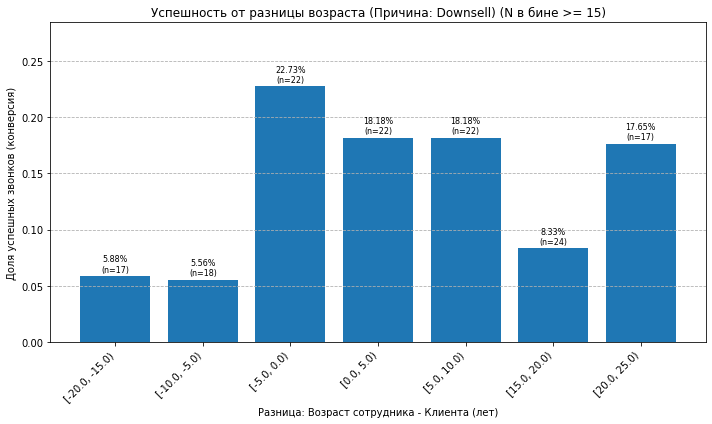

Пропускаем functional_cd 'Activation': слишком мало данных (93 записей)
Пропускаем functional_cd 'Autoleads': слишком мало данных (45 записей)


In [ ]:
# Цвета для графиков
colors = plt.cm.get_cmap('tab20').colors

# Минимальное количество наблюдений в категории, чтобы для нее строился график
MIN_OBS_PER_CATEGORY = 100
# Меньший порог для бинов внутри категории
MIN_BIN_COUNT_FOR_CATEGORY_PLOT = 15

print("--- Анализ по product_cd ---")
unique_products = df['product_cd'].dropna().unique()
for i, product in enumerate(unique_products):
    df_filtered_product = df[df['product_cd'] == product].copy()

    if len(df_filtered_product) < MIN_OBS_PER_CATEGORY:
        print(f"Пропускаем product_cd '{product}': слишком мало данных ({len(df_filtered_product)} записей)")
        continue

    bin_width_ = 10
    if product == "Casco":
      bin_width_ = 5

    current_color = colors[i % len(colors)] # Циклически используем цвета
    print(f"\nГрафик для product_cd: {product}")
    plot_success_rate_by_binned_feature(
        df_source=df_filtered_product,
        feature_column_name='age_difference',
        plot_title=f"Успешность от разницы возраста (Продукт: {product})",
        xlabel_text="Разница: Возраст сотрудника - Клиента (лет)",
        min_bin_count=MIN_BIN_COUNT_FOR_CATEGORY_PLOT,
        bin_width=bin_width_,
        plot_color=current_color
    )

print("\n\n--- Анализ по functional_cd ---")
unique_functionals = df['functional_cd'].dropna().unique()
for i, functional_reason in enumerate(unique_functionals):
    df_filtered_functional = df[df['functional_cd'] == functional_reason].copy()

    if len(df_filtered_functional) < MIN_OBS_PER_CATEGORY:
        print(f"Пропускаем functional_cd '{functional_reason}': слишком мало данных ({len(df_filtered_functional)} записей)")
        continue

    bin_width_ = 10
    if functional_reason in ["Reutilization", "Downsell"]:
      bin_width_ = 5

    current_color = colors[(i + len(unique_products)) % len(colors)]
    print(f"\nГрафик для functional_cd: {functional_reason}")
    plot_success_rate_by_binned_feature(
        df_source=df_filtered_functional,
        feature_column_name='age_difference',
        plot_title=f"Успешность от разницы возраста (Причина: {functional_reason})",
        xlabel_text="Разница: Возраст сотрудника - Клиента (лет)",
        min_bin_count=MIN_BIN_COUNT_FOR_CATEGORY_PLOT,
        bin_width=bin_width_,
        plot_color=current_color
    )

Как мы видим, во многих категориях сохраняется зависимость, близкая к линейной. Но в зависисомти от категории коэффициент наклона может меняться. Поэтому:

1. Выявим категории, в которых зависимость близка к линейной.
2. Для каждой такой категории рассчитаем коэффициент наклона прямой
3. Внесем поправки в вероятности, выдаваемые обученной нами ранее моделью логистической регрессии, с учётом рассчитанных коэффициентов.
4. Оценим качество скорректированных прогнозов: сравним метрики до и после добавления возрастных поправок.

Таким образом, мы интегрируем в модель знание о специфическом влиянии возрастной разницы внутри отдельных категорий, чтобы повысить точность предсказаний.

In [ ]:
diff_threshold = 40

# Списки категорий с линейной зависимостью
linear_product_cd = ["Debit Cards", "Cash Loan", "Car Loan", "MVNO"]
linear_functional_cd = ["Reutilization", "Agreement", "Afterfilling", "Downsell", "Preapprove", "Utilization", "Meeting"]

print("\n--- Шаг 1: Обучение OLS моделей для категорий ---")
category_params = {}

df_for_ols = df.copy()

# Обработка product_cd
for product in linear_product_cd:
    df_cat = df_for_ols[
        (df_for_ols['product_cd'] == product) &
        (np.abs(df_for_ols['age_difference']) <= diff_threshold)
    ].copy()
    df_cat.dropna(subset=['age_difference', 'call_success_flag'], inplace=True)

    if len(df_cat) < 50: # Минимальное количество наблюдений для обучения OLS
        print(f"Пропуск product_cd '{product}': мало данных ({len(df_cat)}) для OLS.")
        category_params[('product_cd', product)] = {'slope': 0, 'mean_age_diff': 0, 'valid': False}
        continue

    Y_ols_cat = df_cat['call_success_flag'].astype(float)
    X_ols_cat_feat = df_cat['age_difference']
    X_ols_cat = sm.add_constant(X_ols_cat_feat)

    try:
        model_cat_ols = sm.OLS(Y_ols_cat, X_ols_cat.astype(float))
        results_cat_ols = model_cat_ols.fit()
        slope = results_cat_ols.params.get('age_difference', 0)
        mean_age_diff = df_cat['age_difference'].mean()
        category_params[('product_cd', product)] = {'slope': slope, 'mean_age_diff': mean_age_diff, 'valid': True}
        print(f"Product_cd '{product}': slope={slope:.4f}, mean_age_diff={mean_age_diff:.2f} (N={len(df_cat)})")
    except Exception as e:
        print(f"Ошибка при OLS для product_cd '{product}': {e}")
        category_params[('product_cd', product)] = {'slope': 0, 'mean_age_diff': 0, 'valid': False}


# Обработка functional_cd
for functional in linear_functional_cd:
    df_cat = df_for_ols[
        (df_for_ols['functional_cd'] == functional) &
        (np.abs(df_for_ols['age_difference']) <= diff_threshold)
    ].copy()
    df_cat.dropna(subset=['age_difference', 'call_success_flag'], inplace=True)

    if len(df_cat) < 50:
        print(f"Пропуск functional_cd '{functional}': мало данных ({len(df_cat)}) для OLS.")
        category_params[('functional_cd', functional)] = {'slope': 0, 'mean_age_diff': 0, 'valid': False}
        continue

    Y_ols_cat = df_cat['call_success_flag'].astype(float)
    X_ols_cat_feat = df_cat['age_difference']
    X_ols_cat = sm.add_constant(X_ols_cat_feat)

    try:
        model_cat_ols = sm.OLS(Y_ols_cat, X_ols_cat.astype(float))
        results_cat_ols = model_cat_ols.fit()
        slope = results_cat_ols.params.get('age_difference', 0)
        mean_age_diff = df_cat['age_difference'].mean()
        category_params[('functional_cd', functional)] = {'slope': slope, 'mean_age_diff': mean_age_diff, 'valid': True}
        print(f"Functional_cd '{functional}': slope={slope:.4f}, mean_age_diff={mean_age_diff:.2f} (N={len(df_cat)})")
    except Exception as e:
        print(f"Ошибка при OLS для functional_cd '{functional}': {e}")
        category_params[('functional_cd', functional)] = {'slope': 0, 'mean_age_diff': 0, 'valid': False}

# Применение поправок к предсказаниям на X_test
print("\n--- Шаг 2: Применение категориальных поправок к вероятностям ---")

test_data_original_cols = data.loc[X_test.index, ['product_cd', 'functional_cd', 'age', 'emp_age']].copy()
test_data_original_cols['age_difference'] = test_data_original_cols['emp_age'] - test_data_original_cols['age']

y_pred_prob_original_series_test = pd.Series(y_pred_prob, index=X_test.index)
y_pred_prob_adjusted_series_test = y_pred_prob_original_series_test.copy()

num_corrections_applied = 0
for idx in X_test.index:
    current_product = test_data_original_cols.loc[idx, 'product_cd']
    current_functional = test_data_original_cols.loc[idx, 'functional_cd']
    current_age_diff = test_data_original_cols.loc[idx, 'age_difference']

    slope = 0
    mean_age_diff_for_cat = 0
    correction_applied_for_row = False

    if pd.isna(current_age_diff) or np.abs(current_age_diff) > diff_threshold:
        continue

    key_product = ('product_cd', current_product)
    if key_product in category_params and category_params[key_product]['valid']:
        params = category_params[key_product]
        slope = params['slope']
        mean_age_diff_for_cat = params['mean_age_diff']
        correction_applied_for_row = True

    if correction_applied_for_row and slope != 0:
      baseline_cat_correction = slope * mean_age_diff_for_cat
      current_row_age_effect = slope * current_age_diff

      y_pred_prob_adjusted_series_test.loc[idx] = (
          y_pred_prob_original_series_test.loc[idx] -
          baseline_cat_correction +
          current_row_age_effect
      )
      num_corrections_applied +=1
      correction_applied_for_row = False

    key_functional = ('functional_cd', current_functional)
    if key_functional in category_params and category_params[key_functional]['valid']:
        params = category_params[key_functional]
        slope = params['slope']
        mean_age_diff_for_cat = params['mean_age_diff']
        correction_applied_for_row = True

    if correction_applied_for_row and slope != 0:
        baseline_cat_correction = slope * mean_age_diff_for_cat
        current_row_age_effect = slope * current_age_diff

        y_pred_prob_adjusted_series_test.loc[idx] = (
            y_pred_prob_original_series_test.loc[idx] -
            baseline_cat_correction +
            current_row_age_effect
        )
        num_corrections_applied +=1

print(f"Количество примененных категориальных поправок: {num_corrections_applied}")

# Клиппинг вероятностей
eps = 1e-9
y_pred_prob_adjusted_clipped_test = np.clip(y_pred_prob_adjusted_series_test.values, eps, 1 - eps)
y_pred_prob_original_clipped_test = np.clip(y_pred_prob_original_series_test.values, eps, 1 - eps)

# Расчет метрик
print("\n--- Шаг 3: Расчет Log-Likelihood на тестовой выборке ---")

def calculate_log_likelihood(y_true_labels, pred_probs_class1):
    if isinstance(y_true_labels, pd.Series):
        y_true_arr = y_true_labels.values
    else:
        y_true_arr = y_true_labels
    log_likelihood = np.sum(
        y_true_arr * np.log(pred_probs_class1) +
        (1 - y_true_arr) * np.log(1 - pred_probs_class1)
    )
    return log_likelihood

ll_original_on_test = calculate_log_likelihood(y_test, y_pred_prob_original_clipped_test)
ll_adjusted_on_test = calculate_log_likelihood(y_test, y_pred_prob_adjusted_clipped_test)

print(f"Log-Likelihood для исходной модели на тесте: {ll_original_on_test:.4f}")
print(f"Log-Likelihood для категориально-скорректированной модели на тесте: {ll_adjusted_on_test:.4f}")

avg_ll_original_on_test = ll_original_on_test / len(y_test)
avg_ll_adjusted_on_test = ll_adjusted_on_test / len(y_test)
print(f"Средний Log-Likelihood для исходной модели (на 1 наблюдение): {avg_ll_original_on_test:.6f}")
print(f"Средний Log-Likelihood для категориально-скорректированной модели (на 1 наблюдение): {avg_ll_adjusted_on_test:.6f}")

from sklearn.metrics import roc_auc_score
roc_auc_original = roc_auc_score(y_test, y_pred_prob_original_clipped_test)
roc_auc_adjusted = roc_auc_score(y_test, y_pred_prob_adjusted_clipped_test)

print(f"\nROC AUC для исходной модели на тесте: {roc_auc_original:.4f}")
print(f"ROC AUC для категориально-скорректированной модели на тесте: {roc_auc_adjusted:.4f}")


--- Шаг 1: Обучение OLS моделей для категорий ---
Product_cd 'Debit Cards': slope=0.0018, mean_age_diff=-3.08 (N=1748)
Product_cd 'Cash Loan': slope=0.0012, mean_age_diff=-1.08 (N=2575)
Product_cd 'Car Loan': slope=0.0032, mean_age_diff=-0.33 (N=275)
Product_cd 'MVNO': slope=-0.0005, mean_age_diff=-5.36 (N=1817)
Functional_cd 'Reutilization': slope=0.0058, mean_age_diff=3.48 (N=221)
Functional_cd 'Agreement': slope=0.0026, mean_age_diff=2.43 (N=521)
Functional_cd 'Afterfilling': slope=-0.0004, mean_age_diff=-0.53 (N=2198)
Functional_cd 'Downsell': slope=0.0002, mean_age_diff=4.38 (N=208)
Functional_cd 'Preapprove': slope=0.0003, mean_age_diff=-4.68 (N=8570)
Functional_cd 'Utilization': slope=0.0015, mean_age_diff=-3.32 (N=1618)
Functional_cd 'Meeting': slope=-0.0002, mean_age_diff=7.92 (N=986)

--- Шаг 2: Применение категориальных поправок к вероятностям ---
Количество примененных категориальных поправок: 6191

--- Шаг 3: Расчет Log-Likelihood на тестовой выборке ---
Log-Likelihood дл

### Вывод

В итоге мы повысили точность модели, что говорит о статистической значимости выявленных зависимостей. Зная их, мы можем более эффективно распределять операторов между клиентами и повышать успешность звонков. Например, для параметра product_cd в категориях «Debit Cards», «Cash Loan» и «Car Loan» следует стремиться к максимальной разнице в возрасте между оператором и клиентом, тогда как в категории «MVNO» — наоборот.

### Гипотеза по улучшению продукта
Учитывая эти зависимости, мы сможем более точно подбирать операторов для клиентов, что улучшит их взаимодействие с банком и повысит наши продажи.

# Итоги

Проведённый анализ позволил выявить нетривиальные закономерности и сформулировать три основные гипотезы:

1. Опыт оператора не влияет на успех звонков.

  ➤ Возможно, нет смысла удерживать опытных сотрудников любой ценой — стоит оценить экономику найма и обучения новичков.

2. Pro-подписка снижает общую конверсию, но не везде.

  ➤ В отдельных категориях (дебетовые карты, пролонгация) Pro-подписчики наоборот более лояльны.

  ➤ Предложение: внедрить целевые бонусы для Pro в «слабых» категориях.

3. Возрастная разница влияет на конверсию.

  ➤ Старшие операторы лучше конвертируют молодежь (и наоборот для некоторых продуктов).

  ➤ Предложение: адаптировать распределение звонков под возрастной профиль.

Каждая из гипотез основана на анализе данных и статистическом моделировании. Результаты не только информативны, но и практически применимы — они задают чёткие направления для дальнейших экспериментов и улучшения процессов.